
# K-means Clustering

Author: Jacob Werzinsky (jacob.e.werzinsky.22@dartmouth.edu)

This program takes the folktales and clusters using K-means based on the texts for the Folktales. Then gives a breakdown of the perecentage of each region in each cluster. It also shows a visualization of this in the form of a hierarchical dendrogram and graph visualization. 

Input: texts for 

Output: console output, dendrogram visualization pdf, graph cluster visualization

## Importing Libraries

In [185]:
# Libraries needed for clustering
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import gdown
import string
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

## Getting Folktale Data

In [186]:
url = "https://drive.google.com/uc?id=1-VbDXvxg6kYsccjLWrw5K5o0Iw9JIODD"
output = 'all_regions.csv'
gdown.download(url, output, quiet=False)
!unzip -j $output

df = pd.read_csv('all_regions.csv', header=None)
df.columns = ["Region", "Country/Area", "Text"]

nltk.download('stopwords')
nltk.download('wordnet')

#clean the data
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(text):
    stop_free = ' '.join([word for word in text.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join([lemma.lemmatize(word) for word in punc_free.split()])
    return normalized

df = df.dropna()
df['text_clean']=df['Text'].apply(clean)

df

Downloading...
From: https://drive.google.com/uc?id=1-VbDXvxg6kYsccjLWrw5K5o0Iw9JIODD
To: /content/all_regions.csv
100%|██████████| 7.31M/7.31M [00:00<00:00, 198MB/s]


Archive:  all_regions.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of all_regions.csv or
        all_regions.csv.zip, and cannot find all_regions.csv.ZIP, period.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Region,Country/Area,Text,text_clean
0,Region,Country/Area,Text,text
1,Asia,Arab,In the chronicles of the ancient dynasty of th...,chronicle ancient dynasty sassanidae reigned f...
2,Asia,Arab,"Sire, there was once upon a time a merchant wh...",sire upon time merchant possessed great wealth...
3,Asia,Arab,I am now going to begin my story (said the old...,going begin story said old man please attendth...
4,Asia,Arab,"Great prince of the genii, you must know that ...",great prince genius must know three brothersth...
...,...,...,...,...
744,South America,Brazil,Long ago there was a man and woman who lived i...,long ago man woman lived little mud hut palm t...
745,South America,Brazil,Once upon a time there was a man and his wife ...,upon time man wife poor man earned living maki...
746,South America,Brazil,Once long ago there lived a king who had a stu...,long ago lived king stupid son father sent sch...
747,South America,Brazil,Long years ago there lived a little boy whose ...,long year ago lived little boy whose name mano...


## Creating K-means model

In [187]:
# creating tf-idf matrix
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Text'][1:])
pca = PCA(2) # I use PCA here to make scatter plot visualization work
df2 = pca.fit_transform(X.toarray())

 
#Initialize the class object
kmeans = KMeans(n_clusters= 10, init='k-means++', max_iter=10000, n_init=1)

## Creating Scatter plot Visualization of K-means clusters

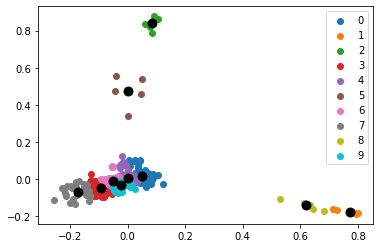

In [188]:
# I modified the code from here to create the scatter plot of the clusters.
# One of the parts I modified was the "X.to.array()" which transforms the sparse dataset to a dense one.
# It took 3 hours to figure out this one change and make this visualization work :( , fml
# source: https://www.askpython.com/python/examples/plot-k-means-clusters-python

label = kmeans.fit_predict(df2)

#filter rows of original data
filtered_label0 = df2[label == 0]
 
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df2[label == i , 0] , df2[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

## Creating bar graph visualization (raw values)

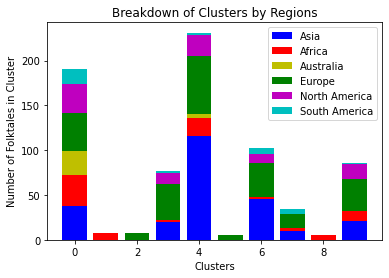

In [189]:
# converting series to list
region_list = []
region_series = df['Region'][1:]
for li in region_series:
    region_list.append(li)  

# dictionary mapping of cluster to its make up in terms of regions
region_make_up = {}

# figuring out make up of cluster
for i in range(len(kmeans.labels_)):
  if kmeans.labels_[i] not in region_make_up:
    region_make_up[kmeans.labels_[i]] = {}
  
  # incrementing the count for this current region in the dictionary of regions
  # and their counts connected to the current cluster
  if region_list[i] not in region_make_up[kmeans.labels_[i]]:
    region_make_up[kmeans.labels_[i]][region_list[i]] = 1
  else:
    region_make_up[kmeans.labels_[i]][region_list[i]] += 1


# manipulating data to make graph
regions = df['Region'][1:].unique()
y = {}
x = []

for cluster in sorted(region_make_up):
  x.append(cluster)

for region in regions:
  y[region] = np.array([])
  for cluster in sorted(region_make_up):
    if region in region_make_up[cluster]:
      y[region] = np.append(y[region], region_make_up[cluster][region])
    else:
      y[region] = np.append(y[region], 0.0)

# creating visualization for region breakdown by cluster
colors = ['b', 'r', 'y', 'g', 'm', 'c']

i = 0
bottom = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.])
for region in regions:
  plt.bar(x, y[region], bottom=bottom, color=colors[i])
  bottom+=y[region]
  i+=1

plt.xlabel("Clusters")
plt.ylabel("Number of Folktales in Cluster")
plt.legend(regions)
plt.title("Breakdown of Clusters by Regions")
plt.show()

## Creating bar graph visualizations (percentages)

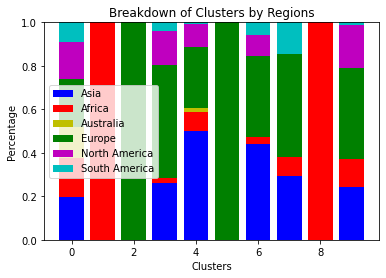

In [190]:
# creating visualization for region breakdown by cluster by percentage
colors = ['b', 'r', 'y', 'g', 'm', 'c']
y = pd.DataFrame.from_dict(y)

# borrowed code from here: https://stackoverflow.com/questions/35678874/normalize-rows-of-pandas-data-frame-by-their-sums
y = y.div(y.sum(axis=1), axis=0)

i = 0
bottom = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.])
for region in regions:
  plt.bar(x, y[region], bottom=bottom, color=colors[i])
  bottom+=y[region]
  i+=1

plt.xlabel("Clusters")
plt.ylabel("Percentage")
plt.legend(regions)
plt.title("Breakdown of Clusters by Regions")
plt.show()

## Hierarchical Dendrogram

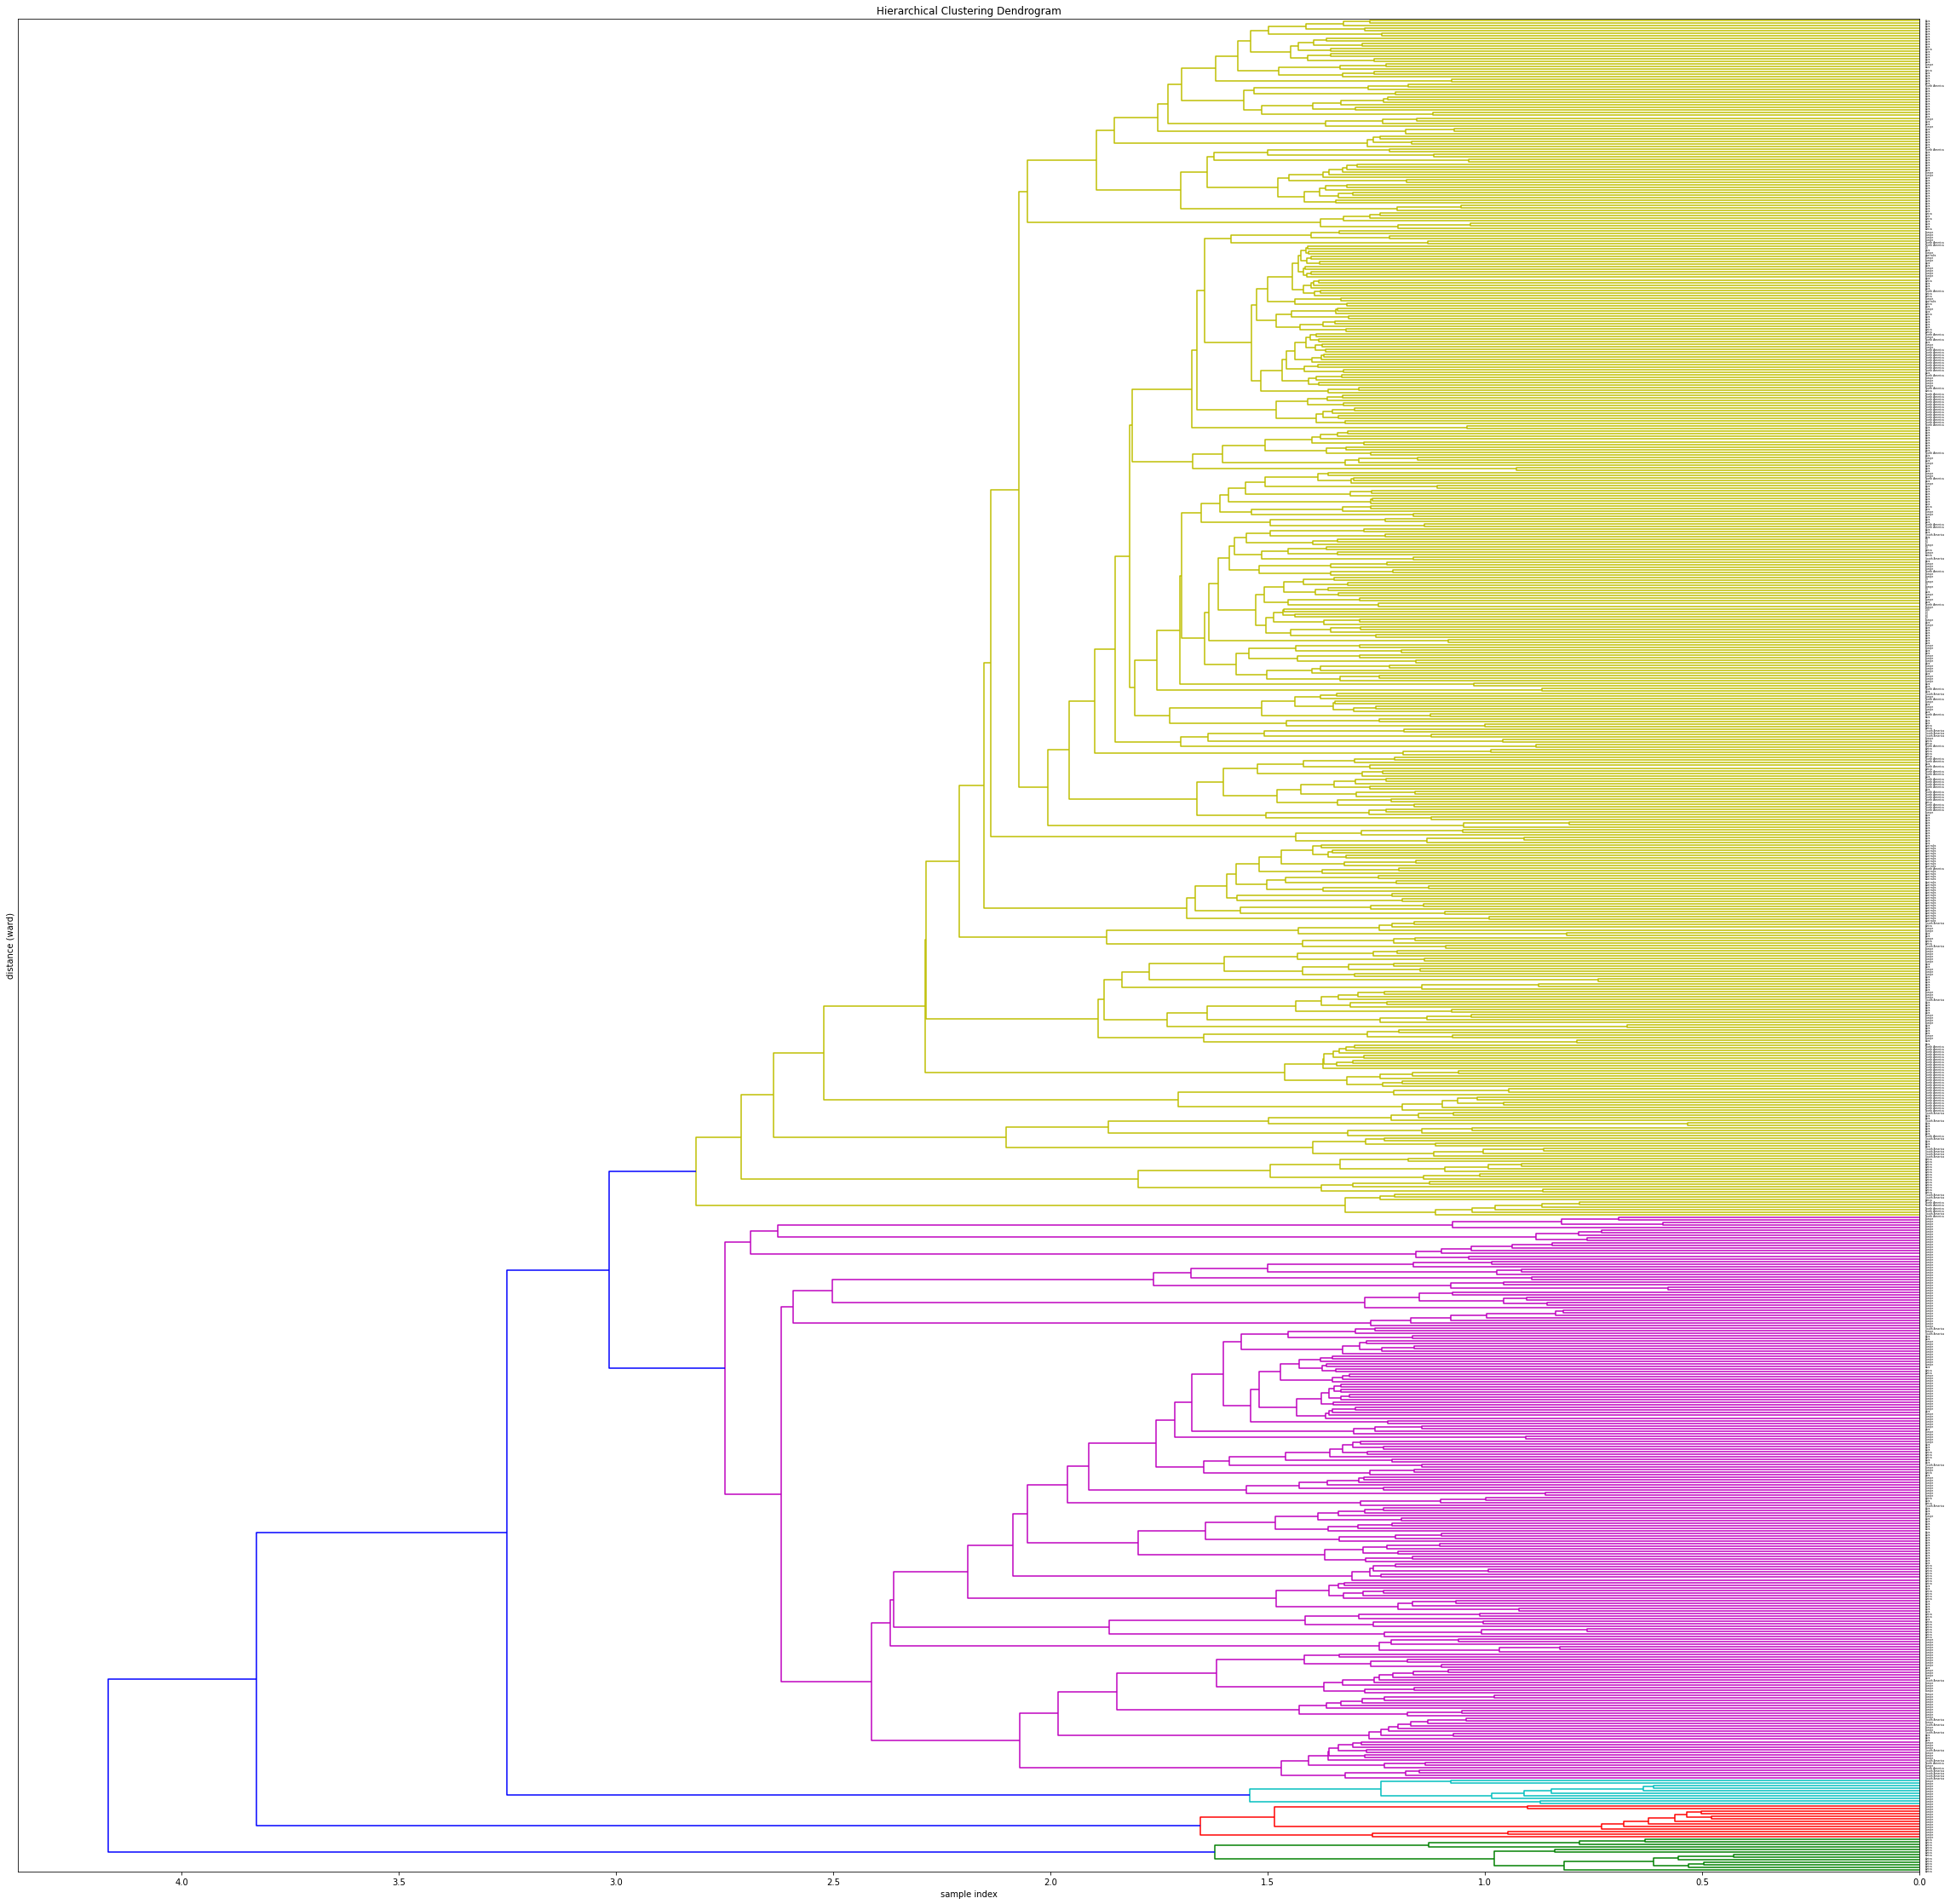

In [191]:
Z = linkage(X.todense(), 'ward')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance (ward)')
dendrogram(Z, orientation="left", labels=region_list,truncate_mode='level', leaf_rotation=0, leaf_font_size=3)

figure = plt.gcf()
figure.set_size_inches(40, 40)

plt.savefig('ie-dendrogram.pdf')

In [192]:
# Download PDF file
from google.colab import files
files.download('ie-dendrogram.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>